# Generate synthetic dataset for Prophet

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet

%matplotlib inline

/home/rani/Desktop/git-repos/traffic-forecast/backend/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [8]:
# Time slots 5 minutes
day = (60/5)*24
month = 30*day
year = 12*month

print(f"[5min] Slots in a day: {day}")
print(f"[5min] Slots in a month: {month}")
print(f"[5min] Slots in a year: {year}")

in] Slots in a day: 288.0
in] Slots in a month: 8640.0
in] Slots in a year: 103680.0


In [2]:
# Functions

def plot_time_series(time, values, label, mark_days=True, hide_xticks=False, only_day=False):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Flows per sec (f/s)", fontsize=20)
    
    days = int(len(time)/288)
    if hide_xticks:
        plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False
        )
    elif only_day:
        slots_hour=np.array(range(0,24)) * 12
        ticks = ["00:00", "01:00", "02:00","03:00", "04:00","05:00","06:00","07:00","08:00","09:00","10:00","11:00","12:00","13:00","14:00","15:00","16:00","17:00","18:00","19:00","20:00","21:00","22:00","23:00"]
        plt.xticks(slots_hour, labels=ticks, rotation=90)
    else:
        slots_days = np.array(range(0,days)) * 288
        labels = np.array(range(0,days)) + 1
        plt.xticks(slots_days, labels=labels, rotation=90)
    
    if mark_days:
        for day in range(0, days):
            plt.axvline(x=day*287, color='b', label=f'day {day}', linestyle='dashed')
    
    plt.title(label, fontsize=20)
    plt.grid(True)
    #plt.legend()


def generate_week(values_5min, beta_weekend, alpha_season=1.0):
    # Week start on Sunday

    seasonal = []
    for i in range(7):
        for j in range(int(day)):
            if i==0 or i==1 or i == 7:
                seasonal.append((values_5min[j] * alpha_season)* beta_weekend)
            else:
                seasonal.append((values_5min[j] * alpha_season))

    # Best performance outside
    #seasonal = seasonal + np.arange(int(day*7))*trend
    return seasonal


def apply_trend(values, cagr, years=1):
    # Apply CAGR exponential upward
    seasonal = []
    #seasonal = values ** (np.power((1+cagr), years))
    #seasonal = values **(np.power((1+cagr), years))
    seasonal = values + (np.arange(len(values)) ** (cagr))

    return seasonal


def apply_noise(values, noise):
    noise = np.random.randn(len(values))*noise
    values += noise
    return values


def apply_95percentile(values):
    days = len(values) / ((60/5)*24)
    seasonal = []
    for d in range(int(days)):
        values_day = values[0+(d*288):288+(d*288)]
        seasonal.append(np.percentile(values_day, 95))

    return seasonal

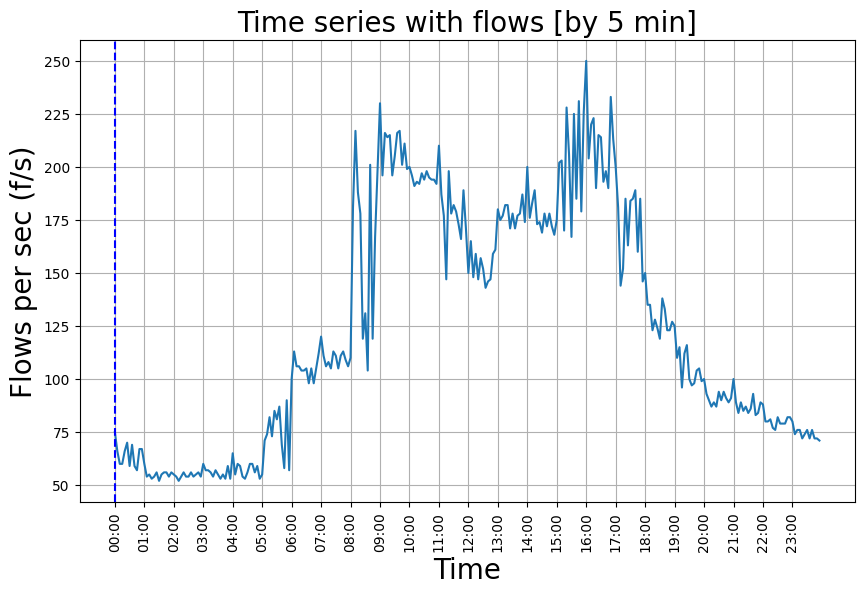

In [5]:
df = pd.read_csv('./data_test/flow_day_5min.csv')

flows_5min_value = df['flow'].to_numpy()
flows_5min_time = df['time'].to_numpy()

plot_time_series(flows_5min_time, flows_5min_value, label="Time series with flows [by 5 min]", only_day=True)

## Generate model to train [with percentile 95]

Days: 749


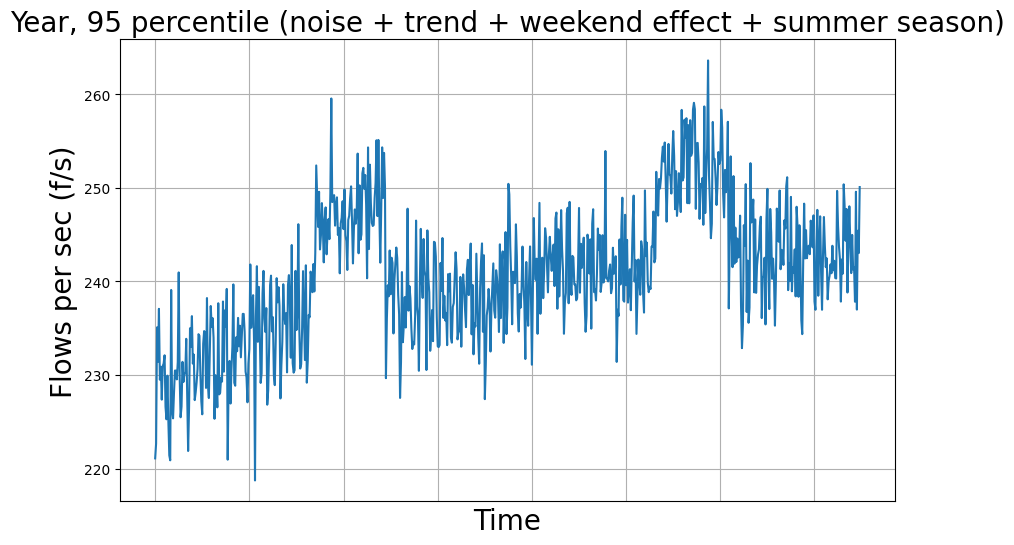

In [153]:
# Vars
weekend = 0.98
season = 1.05
trend_cagr = 0.26
noise = 20

# Weeks in a year, init 01-01, end at 30-12
#weeks = 157     # Three years == 156
weeks = 107
#weeks = 53

values_year_per95 = []
for week in range(weeks):
    # 0 to 12 winter
    # 12 to 24 spring
    # 24 to 36 summer
    # 36 to 48 autum
    if week >= 24 and week <= 34:       # Its summernp.power(
        values_year_per95.append(generate_week(flows_5min_value, beta_weekend=weekend, alpha_season=season))
    elif week >= 76 and week <= 86:    # Its summer
        values_year_per95.append(generate_week(flows_5min_value, beta_weekend=weekend, alpha_season=season))
    elif week >= 128 and week <= 138:    # Its summer
        values_year_per95.append(generate_week(flows_5min_value, beta_weekend=weekend, alpha_season=season))
    else:
        values_year_per95.append(generate_week(flows_5min_value, beta_weekend=weekend))

values_year_per95 = np.concatenate(values_year_per95)  
values_year_per95 = apply_noise(values_year_per95, noise=noise)
values_year_per95 = apply_trend(values_year_per95, cagr=trend_cagr, years=3)
values_year_per95 = apply_95percentile(values=values_year_per95)

print(f"Days: {len(values_year_per95)}")

#time_seasonal = np.arange(int(day*7*weeks))
time_year_per95 = np.arange(len(values_year_per95))
plot_time_series(time_year_per95, values_year_per95, label="Year, 95 percentile (noise + trend + weekend effect + summer season)", mark_days=False, hide_xticks=True)

In [154]:
# Disclaimer, selecting the year may rotate the trend of weekend
# With 52, the weekend trend goes to Saturday-Sunday
#years_later = 56     # 2026
#years_later = 52    # 2022
years_later = 46    # 2016
#years_later = 41    # 2011

# Percentile 95, just 364 entries
values = np.array(values_year_per95)
dataframe_data = np.array([time_year_per95, values]).T
df_year_per95 = pd.DataFrame(dataframe_data, columns=['time', 'flow'])
df_year_per95.time = pd.to_datetime(df_year_per95.time, unit='D')
df_year_per95['time']  = (df_year_per95['time'] + pd.DateOffset(years=years_later)).dt.strftime('%Y-%m-%dT%H:%M:%SZ')
print(f"Year to start: {1970+years_later}")
print(f"Year to finish: {(1970+years_later) + int(weeks/57) + 1}")

# Round flow 
df_year_per95['flow'] = df_year_per95['flow'].round()

df_year_per95.head()

filename = './data_test/output_synthetic_dataset_per95.csv'

df_year_per95.to_csv(filename, index=False)
print("Saved")

Year to start: 2016
Year to finish: 2018
Saved


## Prophet validation

In [155]:
df = pd.read_csv('./data_test/output_synthetic_dataset_per95.csv')

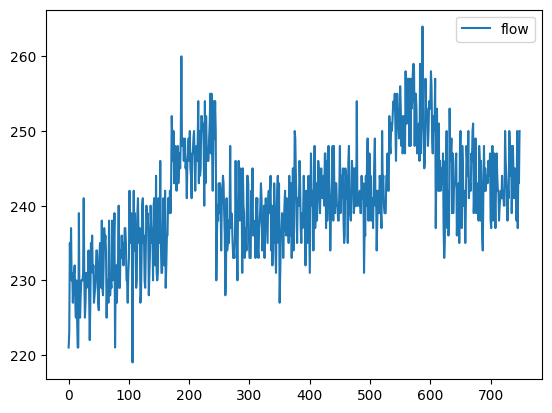

In [156]:
df.plot()
plt.show()
# X axis are months

In [157]:
## Fitting the model
df.columns = ['ds', 'y']        # Fixed by prophet
df['ds'] = pd.to_datetime(df['ds'])    # Force convert month to datetime object

try:
    df['ds'] = df['ds'].dt.tz_convert(None)
except TypeError:
    print("skipping timezone")
    df['ds'] = df['ds']

print(df.head())
print(df.tail())

          ds      y
0 2016-01-01  221.0
1 2016-01-02  223.0
2 2016-01-03  235.0
3 2016-01-04  231.0
4 2016-01-05  237.0
            ds      y
744 2018-01-15  250.0
745 2018-01-16  237.0
746 2018-01-17  245.0
747 2018-01-18  243.0
748 2018-01-19  250.0


In [58]:
# Split the dataset
split_date = '2024-01-01'
train = df[df['ds'] < pd.Timestamp(split_date)]
test = df[df['ds'] >= pd.Timestamp(split_date)]

In [158]:
#model = Prophet(changepoint_prior_scale=0.2, 
#                seasonality_mode='multiplicative',
#                changepoint_range=0.9
#                )
model = Prophet(seasonality_mode='multiplicative')

model.fit(df)

17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing


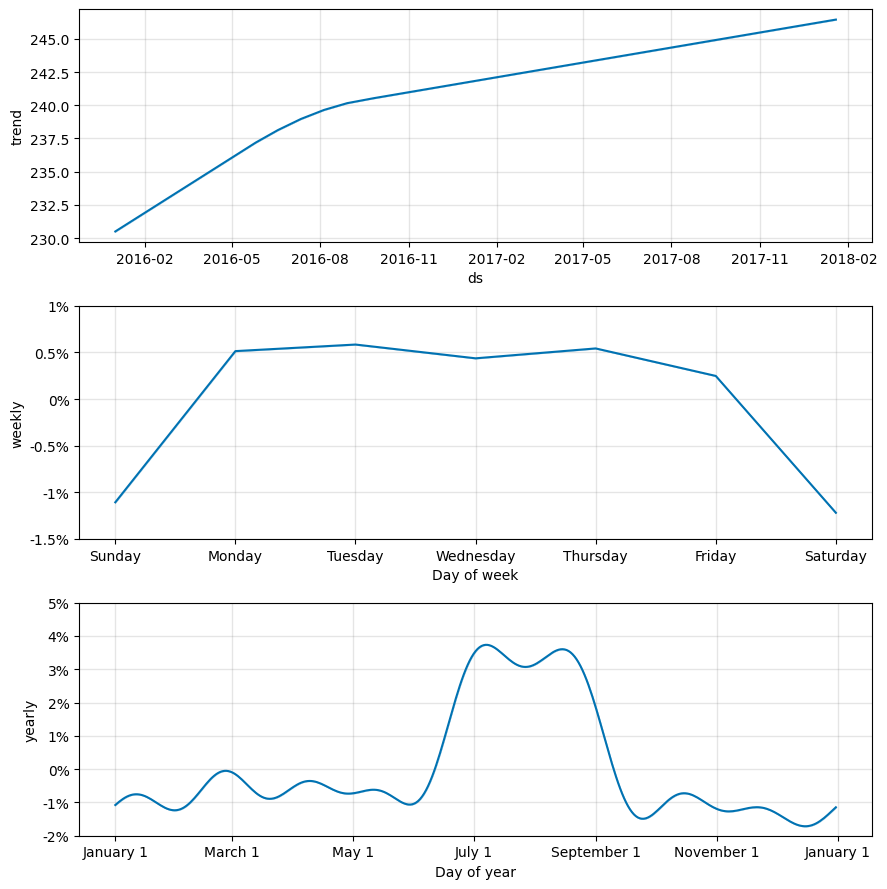

In [159]:
model.plot_components(model.predict(df))
plt.show()

### Forecast one year

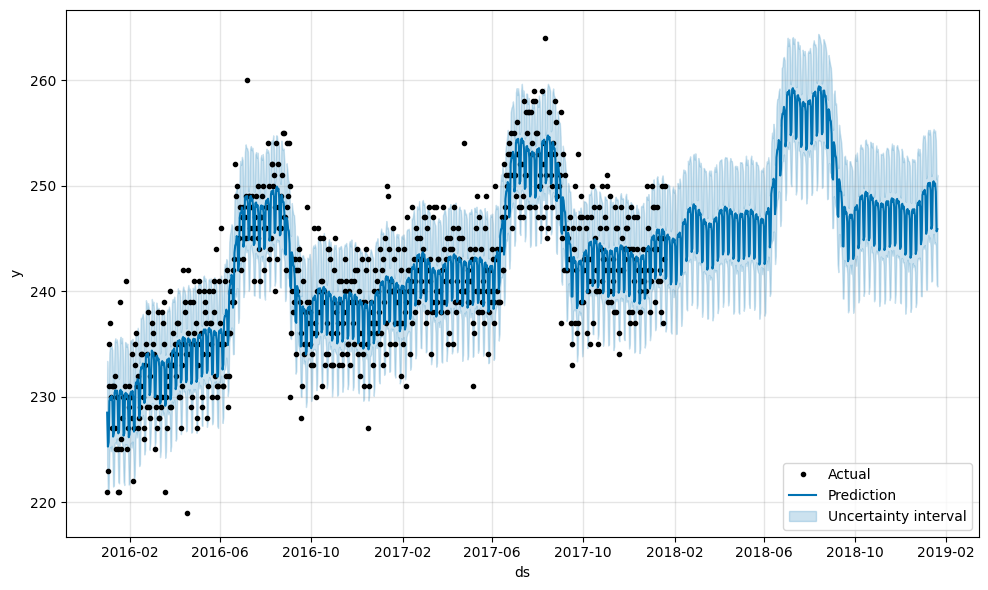

In [160]:
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

model.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'], loc='lower right')
plt.show()

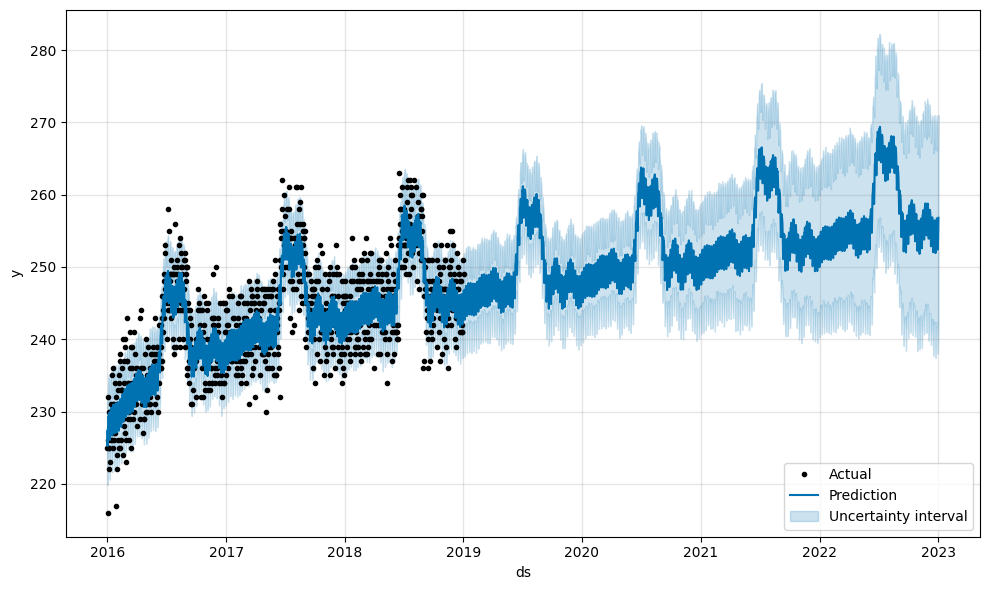

In [120]:
future = model.make_future_dataframe(periods=365*4)
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

model.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'], loc='lower right')
plt.show()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/7 [00:00<?, ?it/s]17:13:49 - cmdstanpy - INFO - Chain [1] start processing
17:13:49 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.92it/s]17:13:49 - cmdstanpy - INFO - Chain [1] start processing
17:13:49 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:00<00:02,  2.32it/s]17:13:50 - cmdstanpy - INFO - Chain [1] start processing
17:13:50 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:01,  2.57it/s]17:13:50 - cmdstanpy - INFO - Chain [1] start processing
17:13:50 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:01<00:01,  2.18it/s]17:13:51 - cmdstanpy - INFO - Chain [1] start processing
17:13:51 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:02<00:00,  2.30it/s]17:13:51 - cmdstanpy - INFO - Chain [1] start processing
17:13:51 - c

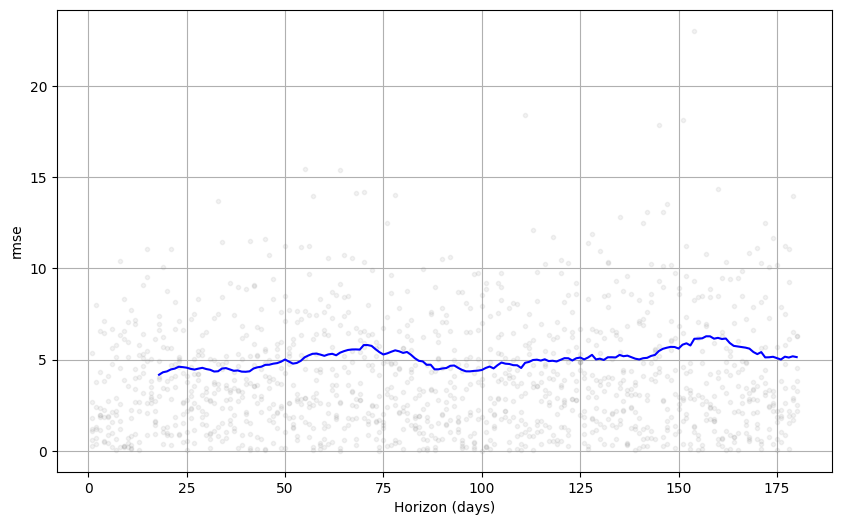

In [121]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='365 days', horizon='180 days')

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [93]:
from prophet.serialize import model_to_json, model_from_json

# Save model
with open('./data_test/serialized_model_per95.json', 'w') as fout:
    fout.write(model_to_json(model))  

# Load model
with open('./data_test/serialized_model_per95.json', 'r') as fin:
    model_loaded = model_from_json(fin.read())  

/home/rani/Desktop/git-repos/traffic-forecast/backend/env/lib/python3.10/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


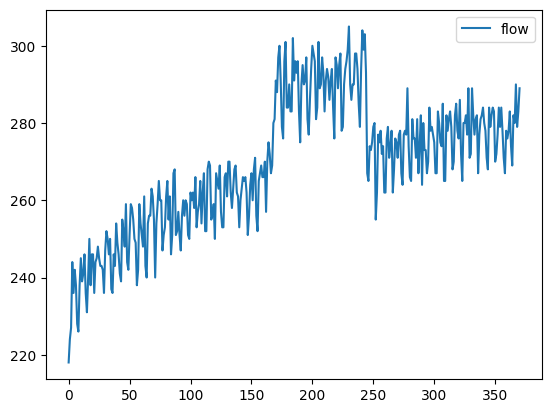

In [98]:
# Load new data, with only one year
df_new = pd.read_csv('./data_test/output_synthetic_dataset_per95.csv')
df_new.plot()
plt.show()
# X axis are months

In [99]:
## Fitting the model
df_new.columns = ['ds', 'y']        # Fixed by prophet
df_new['ds'] = pd.to_datetime(df_new['ds'])    # Force convert month to datetime object

try:
    df_new['ds'] = df_new['ds'].dt.tz_convert(None)
except TypeError:
    print("skipping timezone")
    df_new['ds'] = df_new['ds']

df_new.head()
df_new.tail()

,ds,y
366,2027-01-02,280.0
367,2027-01-03,290.0
368,2027-01-04,279.0
369,2027-01-05,283.0
370,2027-01-06,289.0


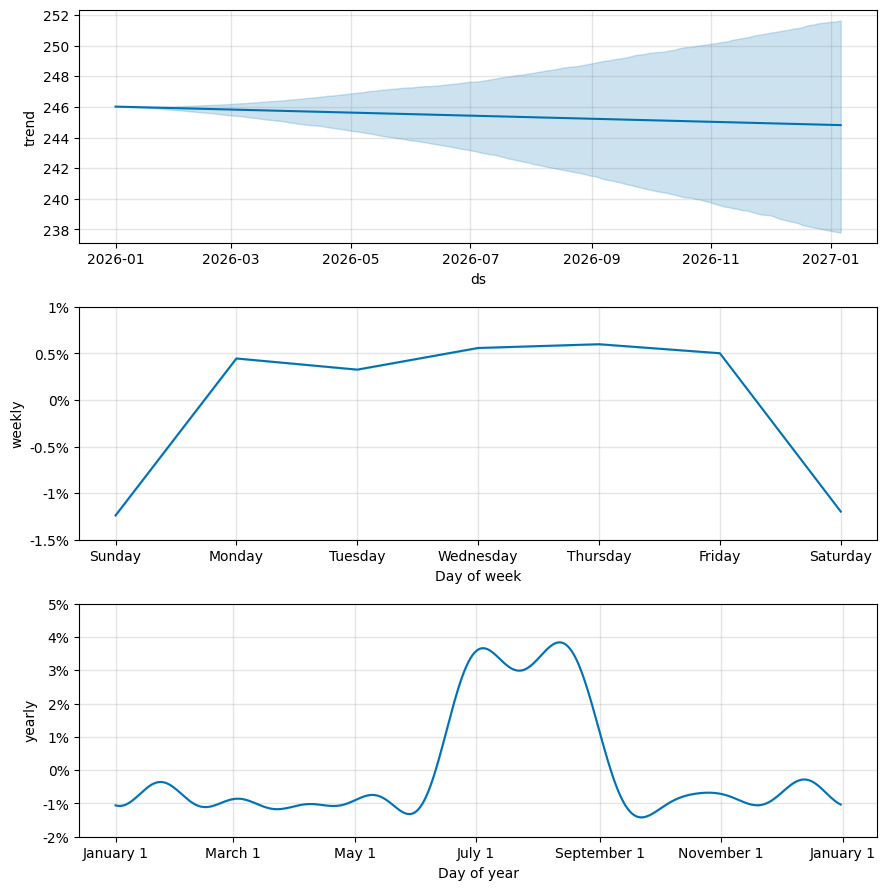

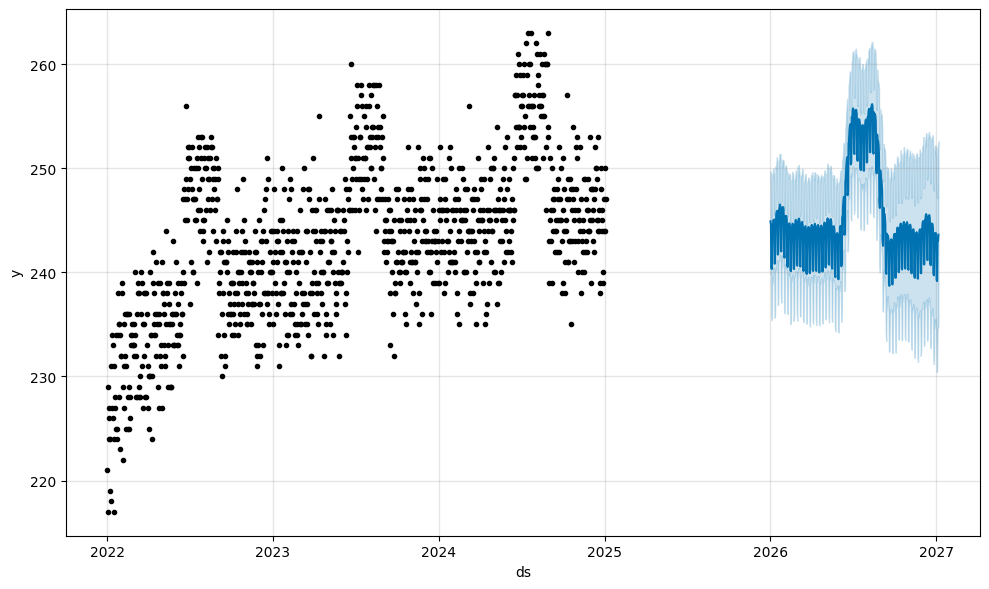

In [100]:
predict = model_loaded.predict(df_new)
#print(predict.tail())

model_loaded.plot_components(predict)
plt.show()

model_loaded.plot(predict)
plt.show()